In [1]:
import librosa
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
data = pd.read_parquet('/kaggle/input/speech-and-music-in-languages/speechAndMusicWLanguages.parquet')

In [3]:
data = data.sample(frac=1)

In [4]:
def preprocess(audio, sr=48000):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    log_mel_spectrogram = (log_mel_spectrogram - np.mean(log_mel_spectrogram)) / np.std(log_mel_spectrogram)
    return log_mel_spectrogram # (128, 282)

In [5]:
def labels_to_int(label):
    if label == 'speech':
        return 1
    else:
        return 0

In [6]:
labels = data['label'].values.tolist()
audios = data['array'].values.tolist()

In [7]:
data.head(3)

,name,array,language_code,label
3860,pt360speech,"[0.0, 2.2471987e-15, 3.9839185e-14, 6.924954e-...",pt,speech
837,es337speech,"[0.0, 2.274603e-14, -3.5452683e-15, 2.5475219e...",es,speech
7883,nl0_53music,"[-0.025310567, 0.007154423, 0.036610972, 0.038...",nl,music


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(64 * 32 * 70, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [10]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, audios, labels):
        self.audios = audios
        self.labels = labels

    def __len__(self):
        return len(self.audios)

    def __getitem__(self, idx):
        label = labels_to_int(self.labels[idx])
        mel_spec = preprocess(self.audios[idx])
        mel_spec = torch.tensor(mel_spec).unsqueeze(0).float()
        label = torch.tensor(label).unsqueeze(0).float()
        return mel_spec, label

In [11]:
def plot_training_loss(losses):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, losses, label='Training Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [12]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        with tqdm(train_loader, desc=f'epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for data in pbar:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                running_loss += loss.item()
                pbar.set_postfix(loss=running_loss/len(train_loader))
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.5f}")
    plot_training_loss(train_losses)

In [13]:
train_dataset = AudioDataset(audios[:7199], labels[:7199])
test_dataset = AudioDataset(audios[7200:-1], labels[7200:-1])

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

In [15]:
model = AudioCNN()
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

epoch 1/20: 100%|██████████| 450/450 [02:15<00:00,  3.32batch/s, loss=0.101]


Epoch 1/20 - Loss: 0.10104


epoch 2/20: 100%|██████████| 450/450 [01:56<00:00,  3.88batch/s, loss=0.0347]


Epoch 2/20 - Loss: 0.03472


epoch 3/20: 100%|██████████| 450/450 [01:58<00:00,  3.81batch/s, loss=0.0127]


Epoch 3/20 - Loss: 0.01272


epoch 4/20: 100%|██████████| 450/450 [01:51<00:00,  4.04batch/s, loss=0.0101]


Epoch 4/20 - Loss: 0.01006


epoch 5/20: 100%|██████████| 450/450 [01:53<00:00,  3.97batch/s, loss=0.0053]


Epoch 5/20 - Loss: 0.00530


epoch 6/20: 100%|██████████| 450/450 [01:53<00:00,  3.96batch/s, loss=0.0026]


Epoch 6/20 - Loss: 0.00260


epoch 7/20: 100%|██████████| 450/450 [01:53<00:00,  3.97batch/s, loss=0.00271]


Epoch 7/20 - Loss: 0.00271


epoch 8/20: 100%|██████████| 450/450 [01:53<00:00,  3.98batch/s, loss=0.000462]


Epoch 8/20 - Loss: 0.00046


epoch 9/20: 100%|██████████| 450/450 [01:49<00:00,  4.12batch/s, loss=0.00219]


Epoch 9/20 - Loss: 0.00219


epoch 10/20: 100%|██████████| 450/450 [01:52<00:00,  3.99batch/s, loss=0.000386]


Epoch 10/20 - Loss: 0.00039


epoch 11/20: 100%|██████████| 450/450 [01:52<00:00,  3.99batch/s, loss=0.00129]


Epoch 11/20 - Loss: 0.00129


epoch 12/20: 100%|██████████| 450/450 [01:52<00:00,  3.99batch/s, loss=0.000504]


Epoch 12/20 - Loss: 0.00050


epoch 13/20: 100%|██████████| 450/450 [01:53<00:00,  3.98batch/s, loss=0.000651]


Epoch 13/20 - Loss: 0.00065


epoch 14/20: 100%|██████████| 450/450 [01:50<00:00,  4.07batch/s, loss=0.000486]


Epoch 14/20 - Loss: 0.00049


epoch 15/20: 100%|██████████| 450/450 [01:51<00:00,  4.03batch/s, loss=0.000354]


Epoch 15/20 - Loss: 0.00035


epoch 16/20: 100%|██████████| 450/450 [01:52<00:00,  3.98batch/s, loss=0.000501]


Epoch 16/20 - Loss: 0.00050


epoch 17/20: 100%|██████████| 450/450 [01:52<00:00,  4.00batch/s, loss=0.000933]


Epoch 17/20 - Loss: 0.00093


epoch 18/20: 100%|██████████| 450/450 [01:49<00:00,  4.11batch/s, loss=0.000581]


Epoch 18/20 - Loss: 0.00058


epoch 19/20: 100%|██████████| 450/450 [01:54<00:00,  3.94batch/s, loss=0.000623]


Epoch 19/20 - Loss: 0.00062


epoch 20/20: 100%|██████████| 450/450 [01:49<00:00,  4.10batch/s, loss=0.000118]


Epoch 20/20 - Loss: 0.00012


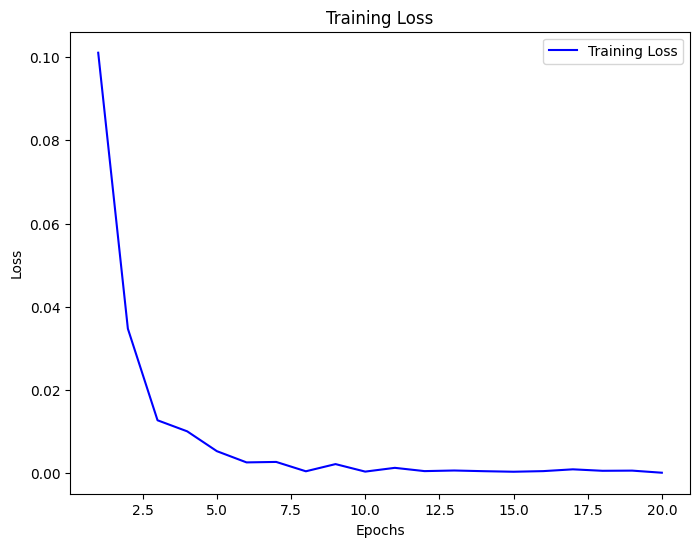

In [16]:
train_model(model, train_loader, criterion, optimizer)

In [17]:
def test_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            predicted = (outputs > 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)    
    return accuracy, precision, recall, f1

In [18]:
accuracy, precision, recall, f1 = test_model(model, test_loader)
print(f"Test Results - Accuracy: {accuracy*100:.5f}%, Precision: {precision:.5f}, Recall: {recall:.5f}, F1 Score: {f1:.5f}")

Test Results - Accuracy: 99.33296%, Precision: 1.00000, Recall: 0.98656, F1 Score: 0.99324


In [19]:
torch.save(model.state_dict(), 'speech_music_classificator.pth')